# Note:

**В этом ноутбуке, а также в аналогичном для Pyramid рассматривается влияние наличия выбросов в выборке.**

In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error

np.random.seed(123)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Generating data

In [3]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y.squeeze()

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y
    

In [4]:
Time = np.arange(0, 300)

# Plotting features

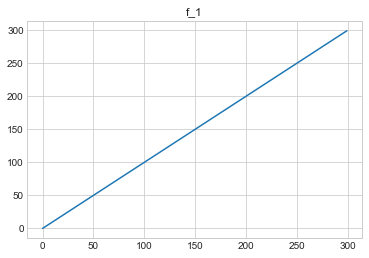

In [5]:
plt.plot(Time,f_1(Time))
plt.title("f_1")
plt.show()

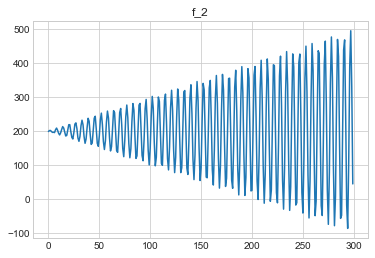

In [6]:
plt.plot(Time,f_2(Time))
plt.title("f_2")
plt.show()

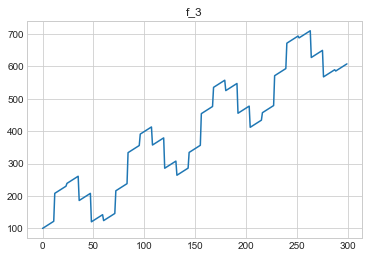

In [7]:
plt.plot(Time,f_3(Time, period=12))
plt.title("f_3")
plt.show()

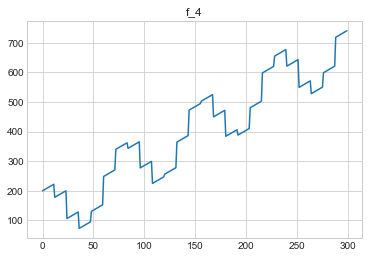

In [8]:
plt.plot(Time,f_4(Time,period=12))
plt.title("f_4")
plt.show()

# Exog features

In [9]:
Exog = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis = 1)

In [10]:
Exog.shape

(300, 4)

# Generating time-series

In [11]:
y_1 = generate_ts_1(Exog)
y_2 = generate_ts_2(Exog)

# Границы train and test

In [12]:
start_point = 80
middle_point = 125
end_point = 175

# Добавим выбросов в данные

In [13]:
np.random.seed(123)

number_of_outliers = 7

idx_1 = np.random.randint(low = start_point, high = middle_point, size = number_of_outliers)
idx_2 = np.random.randint(low = start_point, high = middle_point, size = number_of_outliers)

y_1[idx_1] = y_1[idx_1] + np.random.normal(scale = 50, size = number_of_outliers)
y_2[idx_2] = y_2[idx_2] + np.random.normal(scale = 50, size = number_of_outliers)

# Plotting time-series

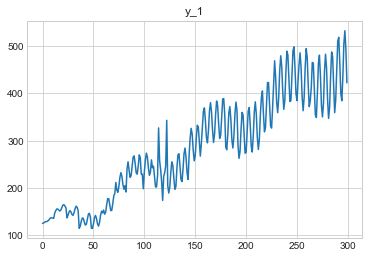

In [14]:
plt.plot(Time,y_1)
plt.title("y_1")
plt.show()

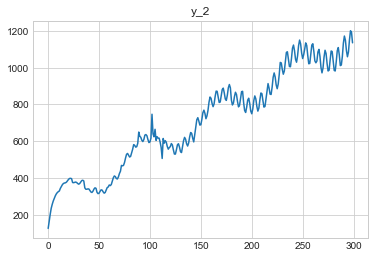

In [15]:
plt.plot(Time,y_2)
plt.title("y_2")
plt.show()

# Prophet Approach

In [16]:
data_1 = pd.DataFrame(y_1)
data_1.columns = ["y"]
data_1["ds"] = pd.date_range(start='1/1/2018', periods=len(data_1), freq='M')

data_2 = pd.DataFrame({"y": y_2})
data_2["ds"] = pd.date_range(start='1/1/2018', periods=len(data_2), freq='M')

exog = pd.DataFrame(Exog)
exog.columns = ["f1", "f2", "f3", "f4"]
exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')

print(data_1.shape, data_2.shape, exog.shape)

(300, 2) (300, 2) (300, 5)


In [17]:
data_1.head()

,y,ds
0,125.191264,2018-01-31
1,126.253121,2018-02-28
2,127.789861,2018-03-31
3,129.008621,2018-04-30
4,129.207194,2018-05-31


In [18]:
data_2.shape

(300, 2)

In [19]:
exog.head()

,f1,f2,f3,f4,ds
0,0.0,200.765055,100.0,200.0,2018-01-31
1,1.0,200.012482,102.0,202.0,2018-02-28
2,2.0,201.159444,104.0,204.0,2018-03-31
3,3.0,201.034484,106.0,206.0,2018-04-30
4,4.0,196.828777,108.0,208.0,2018-05-31


In [20]:
data_train_1 = data_1.iloc[start_point: middle_point]
data_test_1 = data_1.iloc[middle_point: end_point]

data_train_2 = data_2.iloc[start_point: middle_point]
data_test_2 = data_2.iloc[middle_point: end_point]

exog_train = exog.iloc[start_point: middle_point]
exog_test = exog.iloc[middle_point: end_point]

In [21]:
y_test_1 = data_test_1["y"].values
del data_test_1["y"]

y_test_2 = data_test_2["y"].values
del data_test_2["y"]

# 1 Experiment: 1-st dataset without exog

In [22]:
# Python
model = Prophet()

#model.add_seasonality(
#    name='montly', period=7, fourier_order=3, prior_scale=0.1)

model.fit(data_train_1)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [23]:
forecast = model.predict(data_test_1)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
45,2032-03-31,265.116104,236.756814,294.861029
46,2032-04-30,216.952791,188.274523,245.287620
47,2032-05-31,226.357075,199.531877,256.406705
48,2032-06-30,259.180576,230.558593,286.572194
49,2032-07-31,299.006234,270.771145,327.974749


In [24]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_1), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.241 
 MAE:  57.314


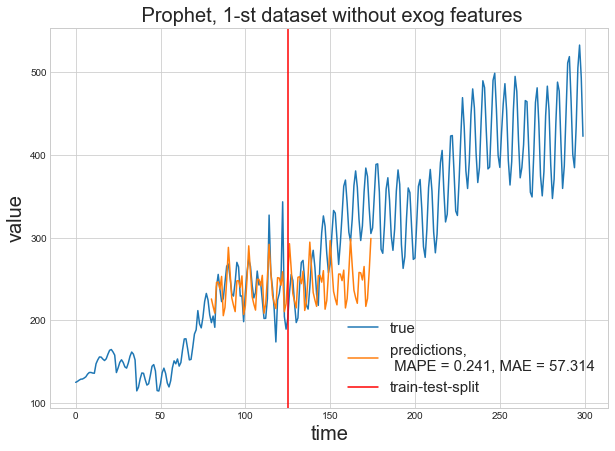

In [25]:
forecast_test = model.predict(data_test_1)
forecast_train = model.predict(data_train_1)

plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point: end_point], np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 1-st dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# 2 Experiment: 2-nd dataset without exog

In [26]:
# Python
model = Prophet(n_changepoints=100, changepoint_range=1)
model.fit(data_train_2)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 44.0.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
forecast = model.predict(data_test_2)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
45,2032-03-31,416.054860,355.387471,479.403752
46,2032-04-30,396.545565,335.367421,461.519968
47,2032-05-31,387.077650,325.138771,447.078356
48,2032-06-30,437.235625,373.485854,505.676854
49,2032-07-31,466.731337,399.748534,529.370212


In [28]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_2), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.496 
 MAE:  225.361


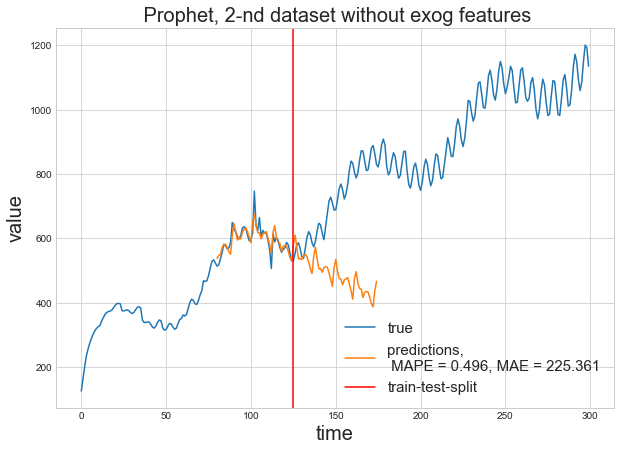

In [29]:
forecast_test = model.predict(data_test_2)
forecast_train = model.predict(data_train_2)

plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point: end_point], np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 2-nd dataset without exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Merging of features

In [30]:
data_train_1_new = pd.merge(data_train_1, exog_train, on = "ds")

data_test_1_new = pd.merge(data_test_1, exog_test, on = "ds")

print(data_train_1_new.shape, data_test_1_new.shape)
data_train_1_new.head()

(45, 6) (50, 5)


,y,ds,f1,f2,f3,f4
0,197.338554,2024-09-30,80.0,121.278736,232.05845,356.017029
1,205.261761,2024-10-31,81.0,147.971564,234.05845,358.017029
2,191.669306,2024-11-30,82.0,224.378974,236.05845,360.017029
3,240.641725,2024-12-31,83.0,279.491421,238.05845,362.017029
4,255.582696,2025-01-31,84.0,261.241897,333.69866,343.390225


# 3-rd Experiment: 1-st dataset with exog features

In [31]:
data_train_2_new = pd.merge(data_train_2, exog_train, on = "ds")

data_test_2_new = pd.merge(data_test_2, exog_test, on = "ds")

print(data_train_2_new.shape, data_test_2_new.shape)
data_train_2_new.head()

(45, 6) (50, 5)


,y,ds,f1,f2,f3,f4
0,513.832347,2024-09-30,80.0,121.278736,232.05845,356.017029
1,517.387245,2024-10-31,81.0,147.971564,234.05845,358.017029
2,535.920624,2024-11-30,82.0,224.378974,236.05845,360.017029
3,556.278596,2024-12-31,83.0,279.491421,238.05845,362.017029
4,581.389124,2025-01-31,84.0,261.241897,333.69866,343.390225


In [32]:
model = Prophet()

model.add_regressor("f1")
model.add_regressor("f2")
model.add_regressor("f3")
model.add_regressor("f4")

model.fit(data_train_1_new)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [33]:
forecast = model.predict(data_test_1_new)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
45,2032-03-31,487.199564,466.540985,509.542983
46,2032-04-30,497.268061,476.908722,517.842371
47,2032-05-31,486.829477,464.498850,507.191243
48,2032-06-30,427.779241,407.426323,447.486719
49,2032-07-31,402.095177,381.677947,423.734201


In [34]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_1), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_1), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.198 
 MAE:  76.107


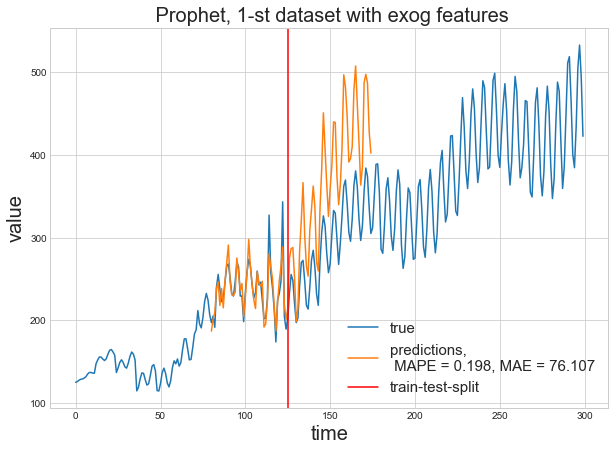

In [35]:
forecast_test = model.predict(data_test_1_new)
forecast_train = model.predict(data_train_1_new)

plt.figure(figsize=(10,7))

plt.plot(Time, y_1, label = "true")
plt.plot(Time[start_point: end_point], np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 1-st dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# 4-th Experiment: 2-nd dataset with exog features

In [36]:
model = Prophet()

model.add_regressor("f1")
model.add_regressor("f2")
model.add_regressor("f3")
model.add_regressor("f4")

model.fit(data_train_2_new)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [37]:
forecast = model.predict(data_test_2_new)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
45,2032-03-31,829.437413,801.347108,859.371421
46,2032-04-30,864.210218,833.966838,893.671930
47,2032-05-31,858.130716,826.383864,889.882406
48,2032-06-30,794.955186,764.735753,825.390138
49,2032-07-31,783.207549,752.208832,812.430168


In [38]:
mape = np.round(mean_absolute_percentage_error(forecast["yhat"], y_test_2), 3)

mae = np.round(mean_absolute_error(forecast["yhat"], y_test_2), 3)

print("MAPE: ", mape, '\n', 
      "MAE: ", mae)

MAPE:  0.035 
 MAE:  24.46


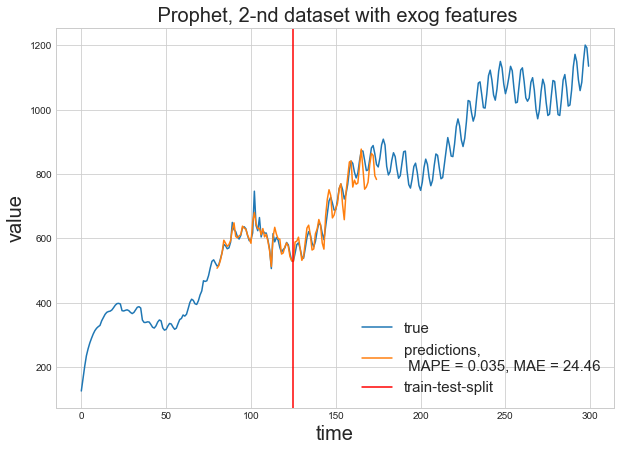

In [39]:
forecast_test = model.predict(data_test_2_new)
forecast_train = model.predict(data_train_2_new)

plt.figure(figsize=(10,7))

plt.plot(Time, y_2, label = "true")
plt.plot(Time[start_point: end_point], np.concatenate([forecast_train["yhat"].values, forecast_test["yhat"].values]), 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(mape, mae))


plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

plt.xlabel("time", size = 20)
plt.ylabel("value", size = 20)
plt.title(" Prophet, 2-nd dataset with exog features", size = 20)



plt.legend(fontsize = 15)

plt.show()

# Model Params:

In [40]:
model.params

{'k': array([[0.07011449]]),
 'm': array([[0.77172112]]),
 'delta': array([[-1.26117722e-09,  8.36771391e-10,  5.93583764e-10,
          4.80991072e-09,  7.07827243e-10, -6.50998994e-09,
          9.05751430e-10, -3.89846209e-09, -2.51702225e-09,
         -2.36369575e-09, -9.75095320e-10, -6.40826578e-10,
         -1.74254009e-06, -1.67009925e-04, -4.85624715e-04,
         -6.95639244e-02, -2.79666161e-02, -1.61932189e-02,
         -1.37470314e-09, -4.07565704e-09, -9.77285158e-10,
         -6.80306873e-09,  8.49702632e-11, -1.50401916e-09,
          6.44990117e-09]]),
 'sigma_obs': array([[0.02316093]]),
 'beta': array([[-0.00417821, -0.00244225,  0.0518527 ,  0.07313495,  0.12836836,
         -0.07896732,  0.00406033,  0.10856632,  0.13192115,  0.03541501,
         -0.10665381, -0.03004947,  0.12811342,  0.0126753 ,  0.02960513,
         -0.12151606,  0.09043384,  0.10827557,  0.08031296, -0.06275284,
          0.01492158,  0.02926577,  0.03980593,  0.03489273]])}

In [41]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper', 'f1', 'f1_lower', 'f1_upper', 'f2',
       'f2_lower', 'f2_upper', 'f3', 'f3_lower', 'f3_upper', 'f4', 'f4_lower',
       'f4_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

**Видимо, SARIMAX лучше справляется с наличием выбросов в обучающей выборке. Что противоречит выводам в статье Prophet, в которой авторы, наоборот, говорят что их Prophet лучше. Возможно, здесь многое зависит как от самого датасета, так и от выбросов, размера обучаюшей выборки и многого другого. ТРЕБУЕТ ОТДЕЛЬНЫХ ИССЛЕДОВАНИЙ!**

In [42]:
model.

SyntaxError: invalid syntax (<ipython-input-42-e5c9403477cf>, line 1)